### 모듈 import

In [1]:
import requests
from datetime import datetime
import pandas as pd
import time
import ccxt
import numpy as np

### 데이터 전처리

In [3]:
raw_data = pd.read_csv('future_close_20201201_1228.csv')

In [4]:
raw_data['Date'] = raw_data['Date'].map(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
raw_data.set_index('Date', inplace = True)

In [5]:
future_close = raw_data.copy()

In [6]:
future_list = future_close.columns.tolist()

In [7]:
small_future = future_close.iloc[-1][future_close.iloc[-1] < 1].index.tolist()

In [8]:
future_close = future_close[small_future]

### 함수 정리

In [9]:
def mom_backtest(frequency, look_period, hold_period, option) :
    
    buy_fee = 0.0005
    sell_fee =  0.0005

    future_ret  = future_close.resample('{}T'.format(frequency)).last().pct_change().dropna()
    end_repeat = (len(future_ret) - look_period)
    idx_list = list(range(0,end_repeat,hold_period))

    ### port_ret_list = []
    port_ret_list = []
    date_list = []
    low_num_list = []
    high_num_list = []


    for idx in idx_list : 

        lookback_ret = future_ret.iloc[idx:idx+look_period].add(1).cumprod().iloc[-1]
        low_mom = lookback_ret[lookback_ret < float(lookback_ret.quantile([0.1]))].index.tolist()
        high_mom = lookback_ret[lookback_ret > float(lookback_ret.quantile([0.9]))].index.tolist()

        # mean revert startegy
        port_num = len(high_mom + low_mom)

        # 포트폴리오 갯수 있는지 여부
        # 수수료 10bp
        if port_num > 0 :
            date = future_ret.iloc[idx + look_period : idx + look_period+hold_period].index.unique().tolist()
            hold_ret_h = future_ret[high_mom].iloc[idx + look_period : idx + look_period+hold_period].sum(axis=1)
            hold_ret_l = future_ret[low_mom].iloc[idx + look_period : idx + look_period+hold_period].sum(axis=1)
            
            # momentum vs mean revert 
            if option == 'mom' :
                port_ret = (hold_ret_h - hold_ret_l) / port_num
            elif option == 'revert' :
                port_ret = (hold_ret_l - hold_ret_h) / port_num
            else :
                print('잘못된 옵션 입력')
                error
                
            port_ret[0] = port_ret[0] - buy_fee
            port_ret[-1] = port_ret[-1] - sell_fee
            port_ret_list = port_ret_list + port_ret.tolist()
        else :
            port_ret = 0
            port_ret_list = port_ret_list + ( [0] * hold_period )

        date_list = date_list + date
        low_num_list = low_num_list + ( [len(low_mom)] * len(date) )
        high_num_list = high_num_list + ( [len(high_mom)] * len(date) )
        
    stat = pd.DataFrame()
    stat['Date'] = date_list
    stat.set_index('Date', inplace = True)
    stat['High_num'] = high_num_list
    stat['Low_num'] = low_num_list

    backtest = pd.DataFrame()
    backtest['Date'] = date_list

    # frequency, lookback period, holding period
    parameter_set = '{}M_{}M_{}M'.format(frequency, frequency*look_period, frequency*hold_period)
    backtest[parameter_set] = port_ret_list
    backtest.set_index('Date', inplace = True)

    plus_ret_num = sum(backtest[parameter_set] > 0)
    minus_ret_num = sum(backtest[parameter_set] < 0)
    plus_ret_prob = plus_ret_num / (plus_ret_num + minus_ret_num)
    
    # 양의 수익률 갯수, 음의 수익률 갯수, 양의수익률 확률
    stat2 = [plus_ret_num, minus_ret_num, plus_ret_prob]
    
    return backtest, stat, stat2

### backtest

In [10]:
# parameter_set_pick
# (10, 480, 360, 'mom') -> 3.3일 lookback으로 2.5일 모멘텀 투자 -> 1년 450% 수익
# (5, 6, 36, 'revert') -> 3개월 70% 수익 / 1년 700%
# (10, 6, 36, 'revert') -> 3개월 50% 수익 / 1년 300%
# (3, 6, 48, 'revert') -> 3개월 40% 수익 / 1년 350%

In [11]:
### 추가 데이터셋
# (10, 6, 24, 'revert') ->  3개월 220%
# (10, 12, 24, 'revert') -> 3개월 80%
# (5,6,48, 'revert') -> 3개월 220% 
# (5,12,48, 'revert') -> 3개월 240%

### Grid search

In [16]:
frequency_list       = [3, 5, 10]
lookback_period_list = [6, 12, 24, 36, 48]
holding_period_list  = [6, 12, 24, 36, 48]
option_list = ['mom', 'revert']

In [17]:
cum_ret_list = []
para_list = []
prob_list = []
for option in option_list :
    for frequency in frequency_list :
        for lookback in lookback_period_list :
            for hold in holding_period_list :
                backtest, stat, stat2 = mom_backtest(frequency, lookback, hold, option)
                cum_ret_list.append(float(backtest.add(1).cumprod().iloc[-1]))
                para_list.append(str(frequency) + '_'+ str(lookback) + '_' + str(hold) + '_' + str(option))
                prob_list.append(stat2[2])
                print(str(frequency) + '_'+ str(lookback) + '_' + str(hold) + '_' + str(option))

3_6_6_mom
3_6_12_mom
3_6_24_mom
3_6_36_mom
3_6_48_mom
3_12_6_mom
3_12_12_mom
3_12_24_mom
3_12_36_mom
3_12_48_mom
3_24_6_mom
3_24_12_mom
3_24_24_mom
3_24_36_mom
3_24_48_mom
3_36_6_mom
3_36_12_mom
3_36_24_mom
3_36_36_mom
3_36_48_mom
3_48_6_mom
3_48_12_mom
3_48_24_mom
3_48_36_mom
3_48_48_mom
5_6_6_mom
5_6_12_mom
5_6_24_mom
5_6_36_mom
5_6_48_mom
5_12_6_mom
5_12_12_mom
5_12_24_mom
5_12_36_mom
5_12_48_mom
5_24_6_mom
5_24_12_mom
5_24_24_mom
5_24_36_mom
5_24_48_mom
5_36_6_mom
5_36_12_mom
5_36_24_mom
5_36_36_mom
5_36_48_mom
5_48_6_mom
5_48_12_mom
5_48_24_mom
5_48_36_mom
5_48_48_mom
10_6_6_mom
10_6_12_mom
10_6_24_mom
10_6_36_mom
10_6_48_mom
10_12_6_mom
10_12_12_mom
10_12_24_mom
10_12_36_mom
10_12_48_mom
10_24_6_mom
10_24_12_mom
10_24_24_mom
10_24_36_mom
10_24_48_mom
10_36_6_mom
10_36_12_mom
10_36_24_mom
10_36_36_mom
10_36_48_mom
10_48_6_mom
10_48_12_mom
10_48_24_mom
10_48_36_mom
10_48_48_mom
3_6_6_revert
3_6_12_revert
3_6_24_revert
3_6_36_revert
3_6_48_revert
3_12_6_revert
3_12_12_revert
3_12_24

In [18]:
grid_ret = pd.DataFrame()

In [19]:
grid_ret['cum_ret'] = cum_ret_list
grid_ret['para'] = para_list
grid_ret['prob'] = prob_list

In [20]:
grid_ret.sort_values(by = 'cum_ret')[::-1].head(30)

,cum_ret,para,prob
84,1.576734,3_12_48_revert,0.511366
127,1.487405,10_6_24_revert,0.519068
89,1.274170,3_24_48_revert,0.509269
126,1.248579,10_6_12_revert,0.515713
88,1.224053,3_24_36_revert,0.509402
83,1.209553,3_12_36_revert,0.506237
129,1.194232,10_6_48_revert,0.501894
102,1.176943,5_6_24_revert,0.506345
82,1.168361,3_12_24_revert,0.505383
74,1.150446,10_48_48_mom,0.505450


In [21]:
backtest, stat, stat2 = mom_backtest(3, 12, 48, 'revert')

In [22]:
stat2

[7266, 6943, 0.5113660356112323]

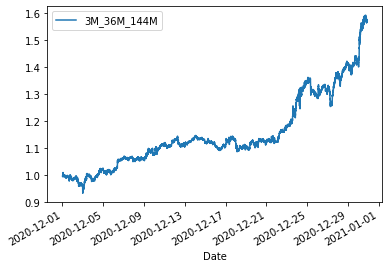

In [23]:
backtest.add(1).cumprod().plot()